# Compare D-scores

## Introduction

In this notebook, we analyze the *apo*-*holo* conformational changes of TCRs and pMHCs using the D-score derived from $\phi$- and $\psi$-angles.
We aim to confirm are previous results that all CDR loops undergo conformational changes but only CDR3 loops are flexible, and further probe the underlying sources of the conformational changes.

### D-score

Described in Mardia & Jupp, 2000 (Directional Statistics), the D-score measures the changes in backbone dihedral angles.

(1) $D(\theta_1, \theta_2) = 2(1 - \cos{(\theta_1 - \theta_2)})$

(2) $\text{D-score}(A, B) = \sum_{i}^{n}(D(\phi_{i}^{A}, \phi_{i}^{B}) + D(\psi_{i}^{A}, \psi_{i}^{B}))$

In [1]:
import os
import itertools

import pandas as pd
import scipy
import seaborn as sns

from tcr_pmhc_interface_analysis.imgt_numbering import IMGT_CDR

In [2]:
DATA_DIR = '../data/processed/apo-holo-tcr-pmhc-class-I-comparisons'

## Load metadata

In [3]:
apo_holo_summary = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I/apo_holo_summary.csv')

apo_holo_summary['id'] = apo_holo_summary['file_name'].str.replace('.pdb', '', regex=False)
apo_holo_summary = apo_holo_summary.set_index('id')

apo_holo_summary

,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug
id,,,,,,,,,,,,
1ao7_D-E-C-A-B_tcr_pmhc,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01
1b0g_C-A-B_pmhc,1b0g_C-A-B_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,C,A,B,NaN,ALWGFFPVL,hla_a_02_01
1b0g_F-D-E_pmhc,1b0g_F-D-E_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,F,D,E,NaN,ALWGFFPVL,hla_a_02_01
1bd2_D-E-C-A-B_tcr_pmhc,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01
1bii_P-A-B_pmhc,1bii_P-A-B_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd
...,...,...,...,...,...,...,...,...,...,...,...,...
7rtd_C-A-B_pmhc,7rtd_C-A-B_pmhc.pdb,7rtd,pmhc,apo,NaN,NaN,C,A,B,NaN,YLQPRTFLL,hla_a_02_01
7rtr_D-E-C-A-B_tcr_pmhc,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01
8gvb_A-B-P-H-L_tcr_pmhc,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02


## Analysis of TCR D-scores

### Load TCR data

In [4]:
tcr_d_score_df = pd.read_csv(os.path.join(DATA_DIR, 'tcr_per_res_apo_holo_d_score.csv'))

In [5]:
tcr_d_score_df = tcr_d_score_df.merge(
    apo_holo_summary[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    apo_holo_summary[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
).merge(
    apo_holo_summary[['cdr_sequences_collated', 'peptide_sequence', 'mhc_slug']],
    how='left',
    left_on='complex_id',
    right_index=True,
)

In [6]:
d_score_df_holo = pd.read_csv(os.path.join(DATA_DIR, 'tcr_per_res_holo_holo_d_score.csv'))

d_score_df_holo['cdr_sequences_collated'] = None

cdr_pattern = r'^[A-Z]+-[A-Z]+-[A-Z]+-[A-Z]+-[A-Z]+-[A-Z]+'
tcr_aligned_complex_ids = d_score_df_holo['complex_id'].str.contains(cdr_pattern)

holo_cdr_sequences_collated = d_score_df_holo[tcr_aligned_complex_ids]['complex_id']
d_score_df_holo.loc[tcr_aligned_complex_ids, 'cdr_sequences_collated'] = holo_cdr_sequences_collated

d_score_df_holo = d_score_df_holo.merge(
    apo_holo_summary[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    apo_holo_summary[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
)

d_score_df_holo_tcr = d_score_df_holo[tcr_aligned_complex_ids]

In [7]:
tcr_d_score_df = pd.concat([tcr_d_score_df, d_score_df_holo_tcr])

In [8]:
tcr_d_score_df['comparison'] = tcr_d_score_df['state_x'] + '-' + tcr_d_score_df['state_y']
tcr_d_score_df['comparison'] = tcr_d_score_df['comparison'].map(
    lambda entry: 'apo-holo' if entry == 'holo-apo' else entry
)

In [9]:
tcr_d_score_df['structure_comparison'] = tcr_d_score_df.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
tcr_d_score_df = tcr_d_score_df.drop_duplicates(['structure_comparison', 'chain_type', 'cdr',
                                         'residue_name', 'residue_seq_id', 'residue_insert_code'])
tcr_d_score_df = tcr_d_score_df.reset_index(drop=True)

In [10]:
tcr_d_score_df = tcr_d_score_df[~tcr_d_score_df['d_score'].isnull()].reset_index(drop=True)

In [11]:
tcr_d_score_df = tcr_d_score_df.groupby(['cdr_sequences_collated',
                                         'comparison',
                                         'chain_type',
                                         'cdr',
                                         'residue_name',
                                         'residue_seq_id',
                                         'residue_insert_code'], dropna=False)['d_score'].apply('mean').reset_index()

In [12]:
tcr_d_score_df['anchor'] = tcr_d_score_df['residue_seq_id'].map(lambda seq_id: seq_id not in IMGT_CDR)

In [13]:
tcr_d_score_df

,cdr_sequences_collated,comparison,chain_type,cdr,residue_name,residue_seq_id,residue_insert_code,d_score,anchor
0,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,alpha_chain,1,ALA,27,NaN,0.138574,False
1,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,alpha_chain,1,ASN,22,NaN,0.076004,True
2,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,alpha_chain,1,CYS,23,NaN,0.009379,True
3,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,alpha_chain,1,GLY,29,NaN,3.322146,False
4,ATGYPS-ATKADDK-ALSDPVNDMR-SGHAT-FQNNGV-ASSLRGR...,apo-holo,alpha_chain,1,LEU,39,NaN,0.073606,True
...,...,...,...,...,...,...,...,...,...
6526,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,beta_chain,3,THR,115,NaN,0.000685,False
6527,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,beta_chain,3,THR,122,NaN,0.192570,True
6528,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,beta_chain,3,TYR,102,NaN,0.003136,True
6529,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,apo-holo,beta_chain,3,TYR,117,NaN,0.032772,False


### Analysis

#### Comparing *apo*-*apo*, *apo*-*holo*, and *holo*-*holo* D-scores for the CDR Loops

In [14]:
cdr_d_scores = (tcr_d_score_df.query('not anchor')
                              .groupby(['cdr_sequences_collated', 'comparison', 'chain_type', 'cdr'],
                                       dropna=False)['d_score']
                              .apply('sum')
                              .reset_index())

In [15]:
cdr_d_scores['similar'] = cdr_d_scores['d_score'] <= 1.5

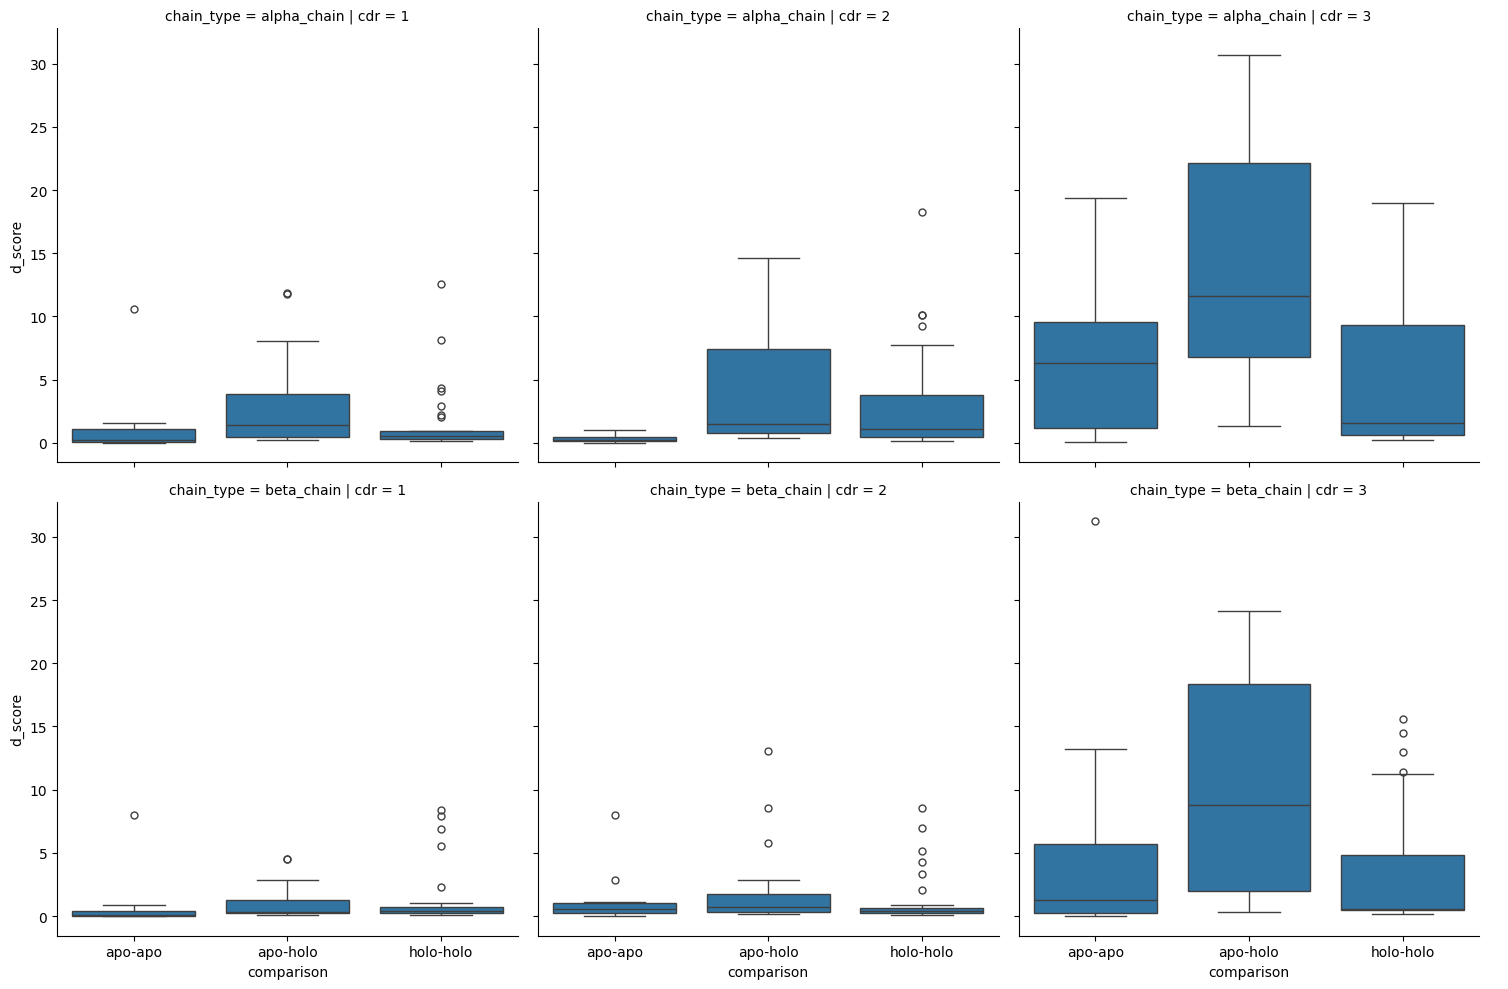

In [16]:
sns.catplot(cdr_d_scores.sort_values('comparison'),
            row='chain_type', col='cdr',
            x='comparison',
            y='d_score',
            kind='box')

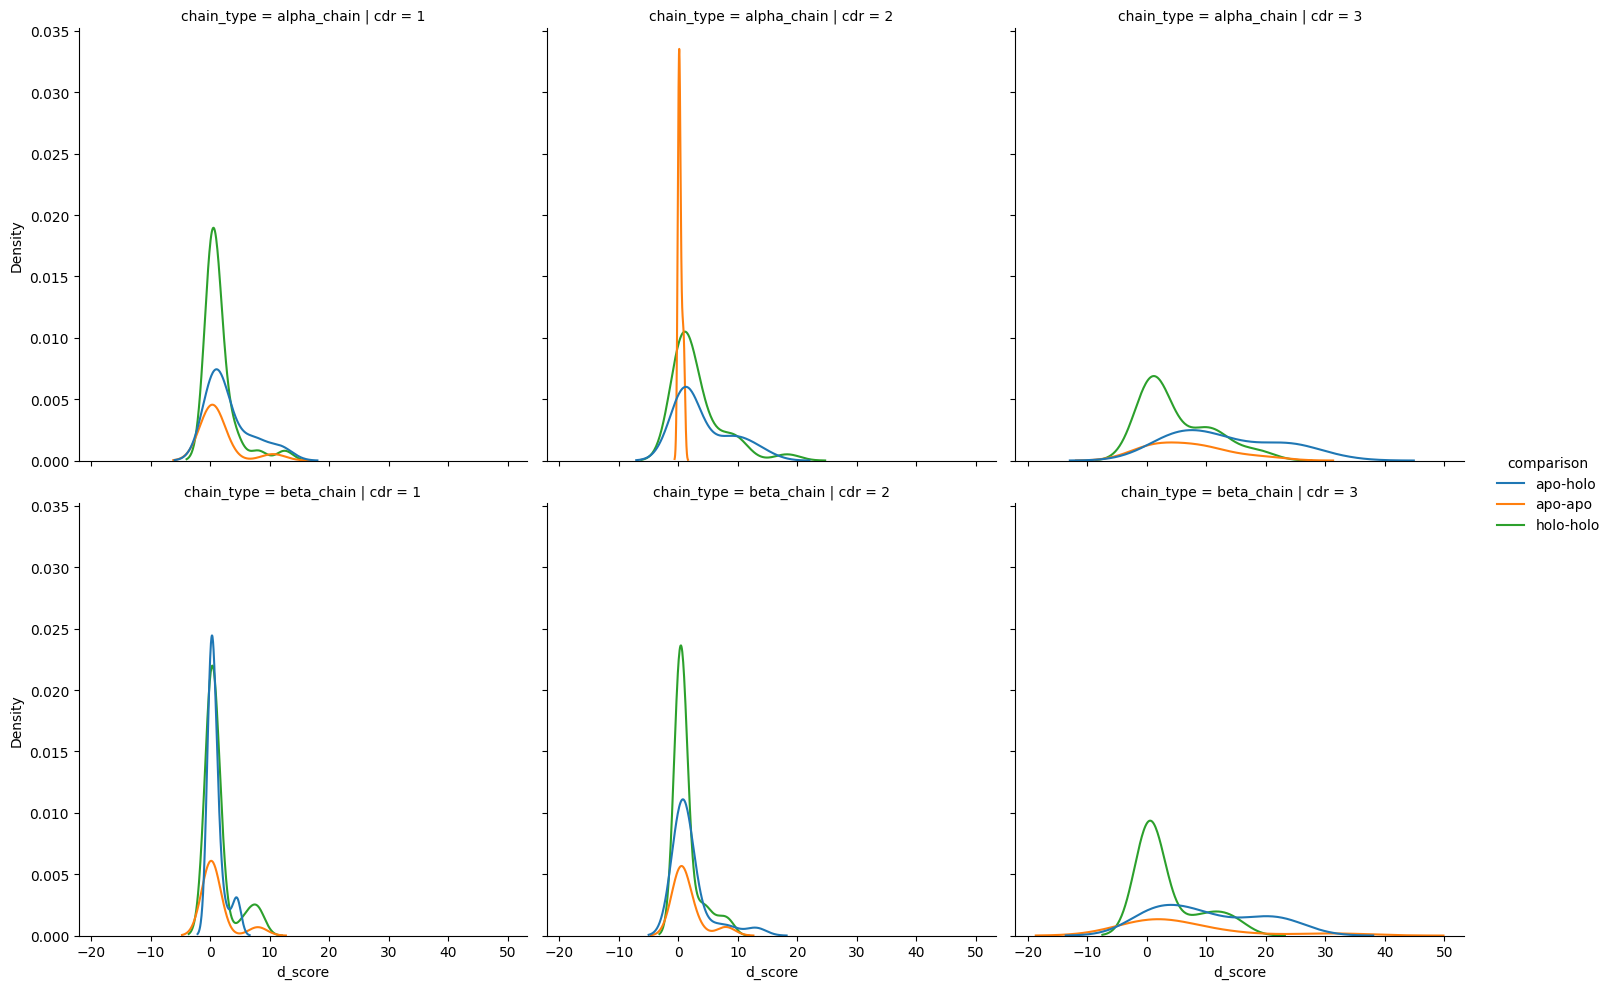

In [17]:
sns.displot(cdr_d_scores,
            row='chain_type', col='cdr',
            hue='comparison',
            x='d_score',
            kind='kde')

In [18]:
treatment_options = ['comparison', 'chain_type', 'cdr']
treatments = [(group, df['d_score'].to_numpy()) for group, df in cdr_d_scores.groupby(treatment_options)]
treatments
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=123.32856486268929, pvalue=3.571547724890704e-18)


In [19]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    chain_type_x = pairing[0][0][1]
    cdr_x = pairing[0][0][2]
    chain_type_y = pairing[1][0][1]
    cdr_y = pairing[1][0][2]

    if (chain_type_x, cdr_x) == (chain_type_y, cdr_y):
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((comparison_x, chain_type_x, cdr_x), sample_x), ((comparison_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y)

    statistics.append(stat)
    p_vals.append(p_val)

d_score_statistics_tcr = pd.DataFrame({
    'comparison_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'comparison_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

d_score_statistics_tcr['p_val'] = d_score_statistics_tcr['p_val'].map(lambda num: f'{num:.2e}')

d_score_statistics_tcr

0.002777777777777778


,comparison_x,chain_type_x,cdr_x,comparison_y,chain_type_y,cdr_y,statistic,p_val,significant
0,apo-apo,alpha_chain,1,apo-holo,alpha_chain,1,-2.450947,1.42e-02,False
1,apo-apo,alpha_chain,1,holo-holo,alpha_chain,1,-1.811616,7.00e-02,False
2,apo-apo,alpha_chain,2,apo-holo,alpha_chain,2,-3.887710,1.01e-04,True
3,apo-apo,alpha_chain,2,holo-holo,alpha_chain,2,-3.404588,6.63e-04,True
4,apo-apo,alpha_chain,3,apo-holo,alpha_chain,3,-1.910822,5.60e-02,False
5,apo-apo,alpha_chain,3,holo-holo,alpha_chain,3,0.437287,6.62e-01,False
6,apo-apo,beta_chain,1,apo-holo,beta_chain,1,-1.870166,6.15e-02,False
7,apo-apo,beta_chain,1,holo-holo,beta_chain,1,-2.061494,3.93e-02,False
8,apo-apo,beta_chain,2,apo-holo,beta_chain,2,-0.935083,3.50e-01,False
9,apo-apo,beta_chain,2,holo-holo,beta_chain,2,-0.093704,9.25e-01,False


#### Per-residue D-score of loop residues

In [20]:
tcr_d_score_df['resi'] = tcr_d_score_df['residue_seq_id'].apply(str) + tcr_d_score_df['residue_insert_code'].fillna('')

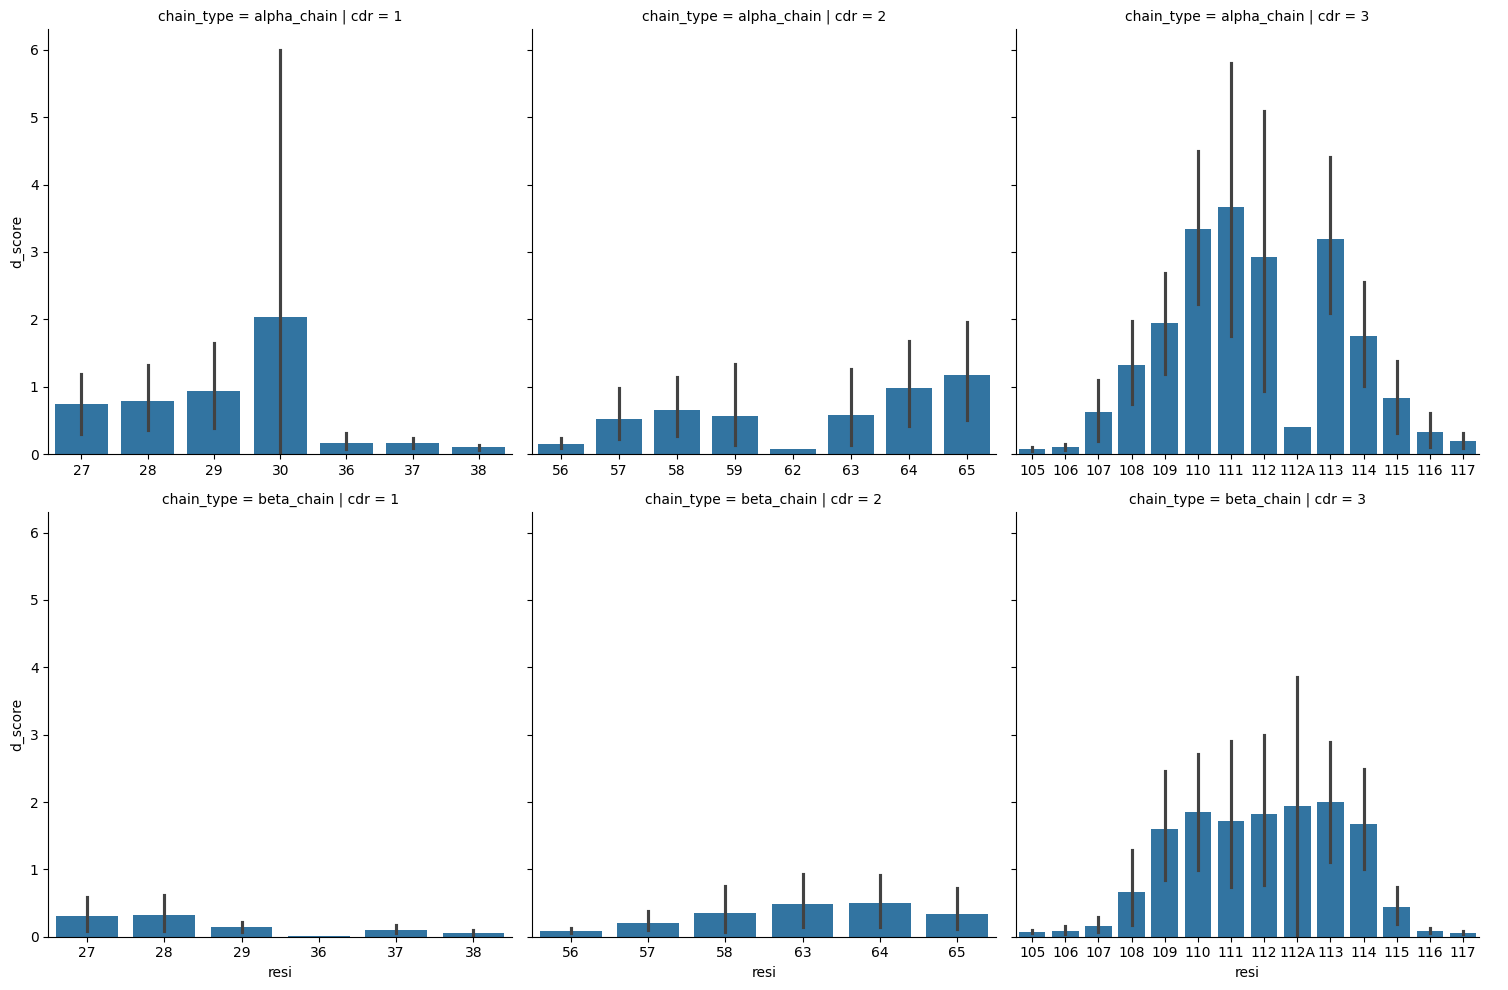

In [21]:
sns.catplot(tcr_d_score_df.query("comparison == 'apo-holo' and not anchor").sort_values(['resi', 'chain_type', 'cdr']),
            row='chain_type', col='cdr',
            x='resi', y='d_score',
            sharex=False,
            kind='bar')

#### Comapring the D-scores of Loop residues versus anchor residues

In [22]:
tcr_d_score_df['classification'] = tcr_d_score_df['anchor'].map(lambda anchor: 'anchor' if anchor else 'loop')

In [23]:
apo_holo_loop_vs_anchor = (tcr_d_score_df.query("comparison == 'apo-holo'")
                                     .groupby(['cdr_sequences_collated',
                                               'chain_type', 'cdr',
                                               'classification'],
                                              dropna=False)['d_score']
                                     .apply('sum')
                                     .reset_index())

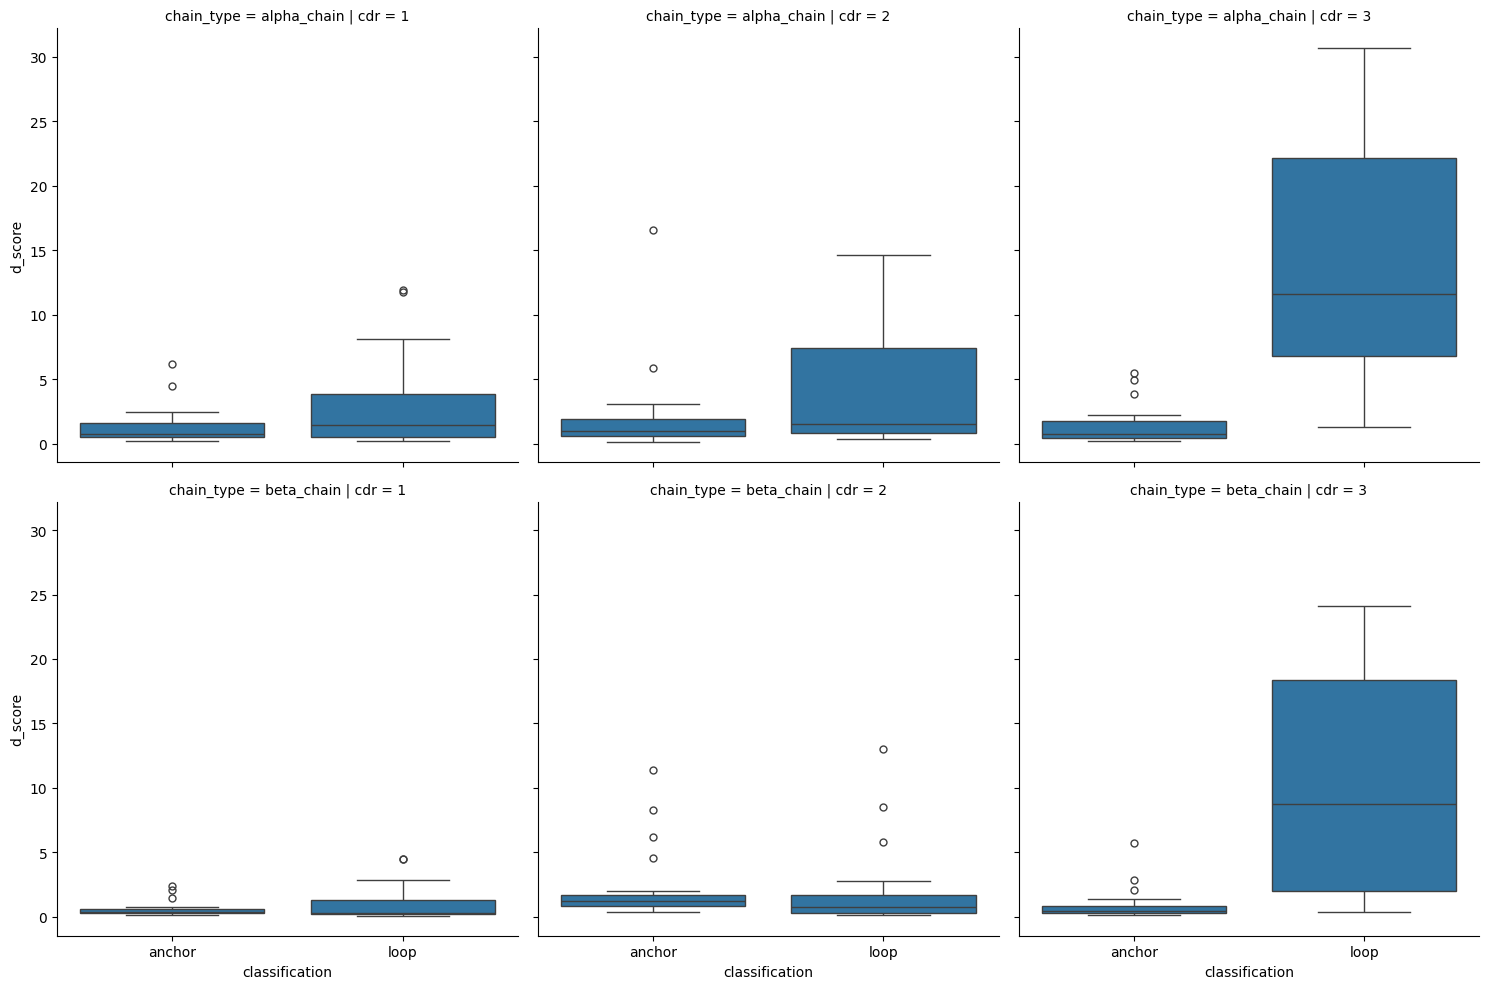

In [24]:
sns.catplot(apo_holo_loop_vs_anchor,
            row='chain_type', col='cdr',
            x='classification',
            y='d_score',
            kind='box')

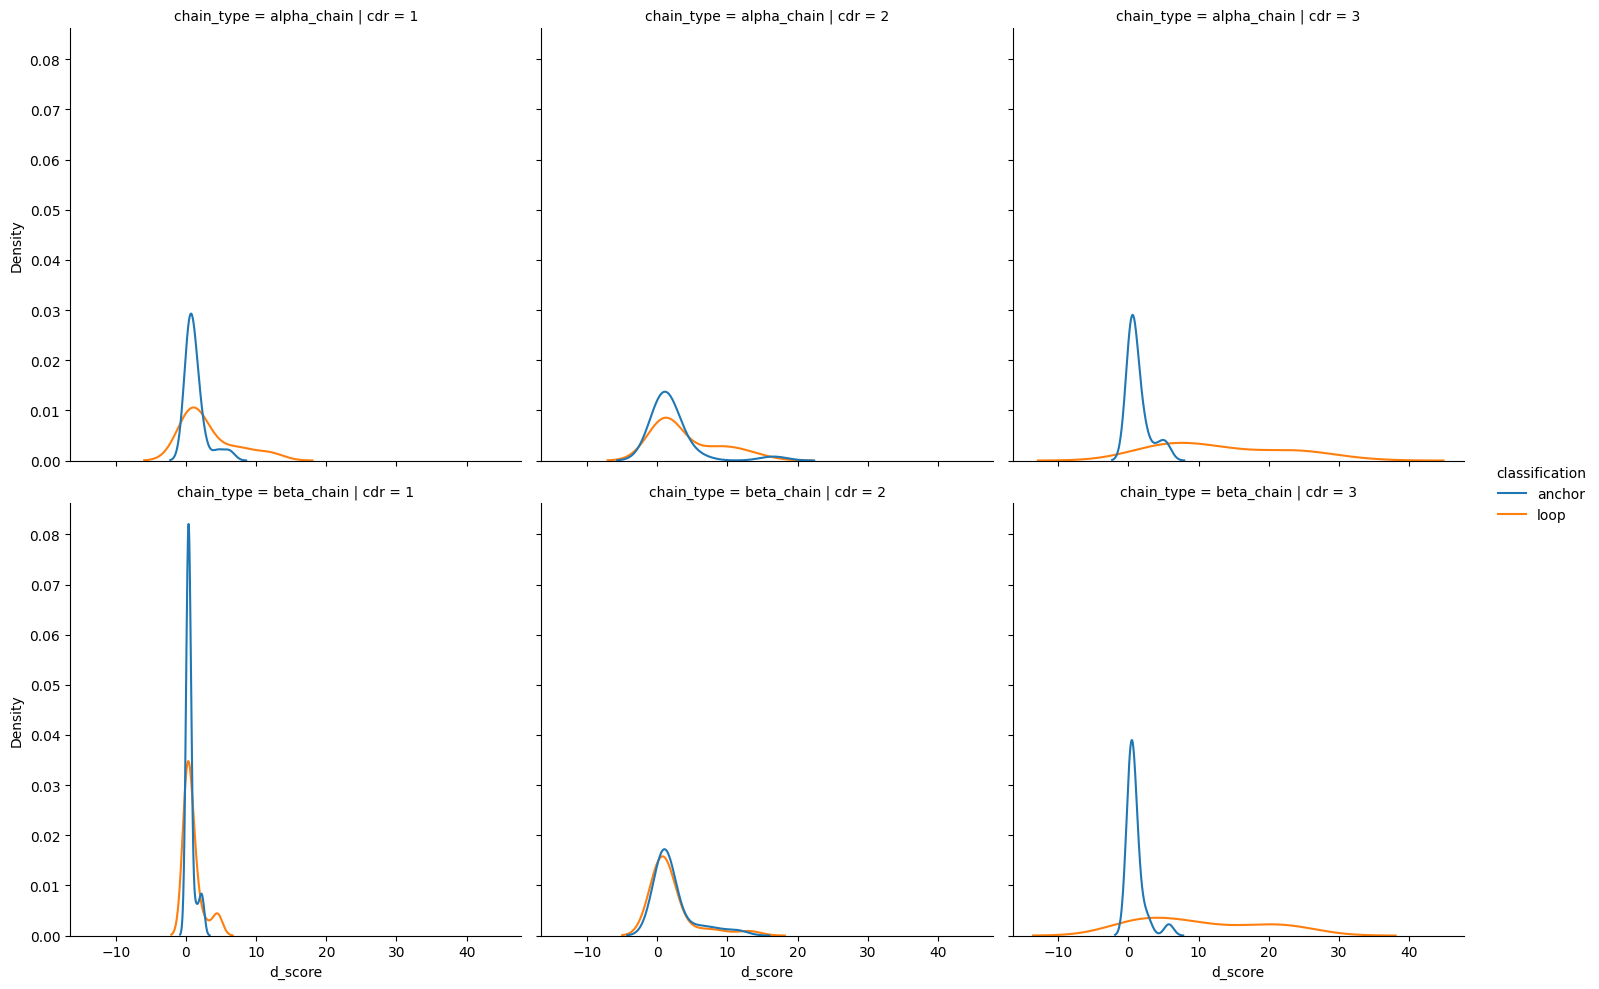

In [25]:
sns.displot(apo_holo_loop_vs_anchor,
            row='chain_type', col='cdr',
            hue='classification',
            x='d_score',
            kind='kde')

In [26]:
treatment_options = ['classification', 'chain_type', 'cdr']
treatments = [(group, df['d_score'].to_numpy()) for group, df in apo_holo_loop_vs_anchor.groupby(treatment_options)]
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=100.36714473266193, pvalue=1.5105310954050626e-16)


In [27]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    chain_type_x = pairing[0][0][1]
    cdr_x = pairing[0][0][2]
    chain_type_y = pairing[1][0][1]
    cdr_y = pairing[1][0][2]

    if (chain_type_x, cdr_x) == (chain_type_y, cdr_y):
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((classification_x, chain_type_x, cdr_x), sample_x), ((classification_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y, alternative='less')

    statistics.append(stat)
    p_vals.append(p_val)

d_score_statistics_loop_anchor = pd.DataFrame({
    'classification_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'classification_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

d_score_statistics_loop_anchor['p_val'] = d_score_statistics_loop_anchor['p_val'].map(lambda num: f'{num:.2e}')

d_score_statistics_loop_anchor

0.008333333333333333


,classification_x,chain_type_x,cdr_x,classification_y,chain_type_y,cdr_y,statistic,p_val,significant
0,anchor,alpha_chain,1,loop,alpha_chain,1,-1.220053,1.11e-01,False
1,anchor,alpha_chain,2,loop,alpha_chain,2,-1.547078,6.09e-02,False
2,anchor,alpha_chain,3,loop,alpha_chain,3,-5.328286,4.96e-08,True
3,anchor,beta_chain,1,loop,beta_chain,1,0.891960,8.14e-01,False
4,anchor,beta_chain,2,loop,beta_chain,2,1.596139,9.45e-01,False
5,anchor,beta_chain,3,loop,beta_chain,3,-4.577162,2.36e-06,True


In [28]:
combos = []
for pairing in list(itertools.combinations(treatments, 2)):
    chain_type_x = pairing[0][0][1]
    cdr_x = pairing[0][0][2]
    chain_type_y = pairing[1][0][1]
    cdr_y = pairing[1][0][2]

    if (chain_type_x, cdr_x) == (chain_type_y, cdr_y):
        combos.append(pairing)

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((classification_x, chain_type_x, cdr_x), sample_x), ((classification_y, chain_type_y, cdr_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y, alternative='greater')

    statistics.append(stat)
    p_vals.append(p_val)

d_score_statistics_loop_anchor = pd.DataFrame({
    'classification_x': [name for ((name, _, _), _), _ in combos],
    'chain_type_x': [name for ((_, name, _), _), _ in combos],
    'cdr_x': [name for ((_, _, name), _), _ in combos],
    'classification_y': [name for _, ((name, _, _), _) in combos],
    'chain_type_y': [name for _, ((_, name, _), _) in combos],
    'cdr_y': [name for _, ((_, _, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

d_score_statistics_loop_anchor['p_val'] = d_score_statistics_loop_anchor['p_val'].map(lambda num: f'{num:.2e}')

d_score_statistics_loop_anchor

0.008333333333333333


,classification_x,chain_type_x,cdr_x,classification_y,chain_type_y,cdr_y,statistic,p_val,significant
0,anchor,alpha_chain,1,loop,alpha_chain,1,-1.220053,8.89e-01,False
1,anchor,alpha_chain,2,loop,alpha_chain,2,-1.547078,9.39e-01,False
2,anchor,alpha_chain,3,loop,alpha_chain,3,-5.328286,1.00e+00,False
3,anchor,beta_chain,1,loop,beta_chain,1,0.891960,1.86e-01,False
4,anchor,beta_chain,2,loop,beta_chain,2,1.596139,5.52e-02,False
5,anchor,beta_chain,3,loop,beta_chain,3,-4.577162,1.00e+00,False


#### Germline (CDR1 and CDR2) loops compared with CDR3 loops

In [29]:
tcr_d_score_df['loop_type'] = tcr_d_score_df['cdr'].map(lambda cdr: 'Germline' if cdr in (1, 2) else 'CDR3')

In [30]:
apo_holo_loop_type = (tcr_d_score_df.query("comparison == 'apo-holo'")
                                .groupby(['cdr_sequences_collated',  'loop_type', 'classification'],
                                         dropna=False)['d_score']
                                .apply('sum')
                                .reset_index())

<AxesSubplot: xlabel='loop_type', ylabel='d_score'>

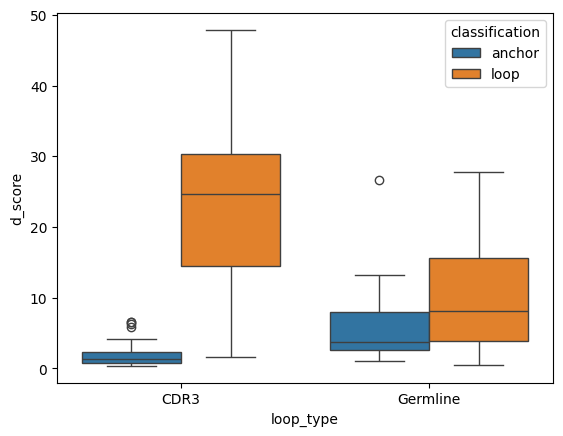

In [31]:
sns.boxplot(apo_holo_loop_type, x='loop_type', y='d_score', hue='classification')

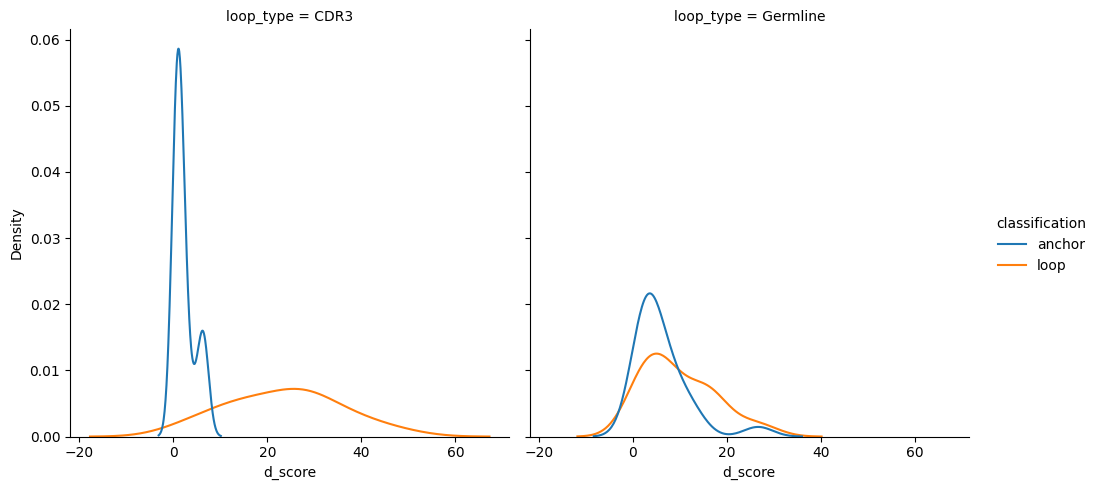

In [32]:
sns.displot(apo_holo_loop_type, x='d_score', col='loop_type', hue='classification', kind='kde')

In [33]:
treatment_options = ['classification', 'loop_type']
treatments = [(group, df['d_score'].to_numpy()) for group, df in apo_holo_loop_type.groupby(treatment_options)]
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=46.51058594112732, pvalue=4.416965854082892e-10)


In [34]:
combos = list(itertools.combinations(treatments, 2))

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for ((classification_x, loop_type_x), sample_x), ((classification_y, loop_type_y), sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y, alternative='two-sided')

    statistics.append(stat)
    p_vals.append(p_val)

d_score_statistics_loop_type = pd.DataFrame({
    'classification_x': [name for ((name, _), _), _ in combos],
    'loop_type_x': [name for ((_, name), _), _ in combos],
    'classification_y': [name for _, ((name, _), _) in combos],
    'loop_type_y': [name for _, ((_, name), _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

d_score_statistics_loop_type['p_val'] = d_score_statistics_loop_type['p_val'].map(lambda num: f'{num:.2e}')

d_score_statistics_loop_type

0.008333333333333333


,classification_x,loop_type_x,classification_y,loop_type_y,statistic,p_val,significant
0,anchor,CDR3,anchor,Germline,-3.591312,3.29e-04,True
1,anchor,CDR3,loop,CDR3,-5.375231,7.65e-08,True
2,anchor,CDR3,loop,Germline,-4.037292,5.41e-05,True
3,anchor,Germline,loop,CDR3,-4.600635,4.21e-06,True
4,anchor,Germline,loop,Germline,-1.713502,8.66e-02,False
5,loop,CDR3,loop,Germline,3.708675,2.08e-04,True


## Analysis of peptide D-scores

### Load pMHC data

In [35]:
pmhc_d_score_df = pd.read_csv(os.path.join(DATA_DIR, 'pmhc_per_res_apo_holo_d_score.csv'))

pmhc_d_score_df = pmhc_d_score_df.merge(
    apo_holo_summary[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    apo_holo_summary[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
).merge(
    apo_holo_summary[['cdr_sequences_collated', 'peptide_sequence', 'mhc_slug']],
    how='left',
    left_on='complex_id',
    right_index=True,
)

In [36]:
d_score_df_holo = pd.read_csv(os.path.join(DATA_DIR, 'pmhc_per_res_holo_holo_d_score.csv'))

d_score_df_holo['mhc_slug'] = None
d_score_df_holo['peptide_sequence'] = None

mhc_pattern = r'^hla|h2'
mhc_alinged_complex_ids = d_score_df_holo['complex_id'].str.contains(mhc_pattern, regex=True)

mhc_slug_peptides = d_score_df_holo[mhc_alinged_complex_ids]['complex_id'].str.rsplit('_', n=1)
mhc_slugs = mhc_slug_peptides.map(lambda composite: composite[0])
peptides = mhc_slug_peptides.map(lambda composite: composite[1])

d_score_df_holo.loc[mhc_alinged_complex_ids, 'mhc_slug'] = mhc_slugs
d_score_df_holo.loc[mhc_alinged_complex_ids, 'peptide_sequence'] = peptides

d_score_df_holo = d_score_df_holo.merge(
    apo_holo_summary[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    apo_holo_summary[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
)

d_score_df_holo_pmhc = d_score_df_holo[mhc_alinged_complex_ids]

In [37]:
pmhc_d_score_df = pd.concat([pmhc_d_score_df, d_score_df_holo_pmhc])

In [38]:
pmhc_d_score_df['comparison'] = pmhc_d_score_df['state_x'] + '-' + pmhc_d_score_df['state_y']
pmhc_d_score_df['comparison'] = pmhc_d_score_df['comparison'].map(
    lambda entry: 'apo-holo' if entry == 'holo-apo' else entry
)

In [39]:
pmhc_d_score_df['structure_comparison'] = pmhc_d_score_df.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
pmhc_d_score_df = pmhc_d_score_df.drop_duplicates(['structure_comparison', 'chain_type', 'tcr_contact',
                                                   'residue_name', 'residue_seq_id', 'residue_insert_code'])
pmhc_d_score_df = pmhc_d_score_df.reset_index(drop=True)

In [40]:
pmhc_d_score_df['peptide_positon'] = None

peptide_positions = (pmhc_d_score_df.query("chain_type == 'antigen_chain'")
                                    .groupby(['complex_id', 'structure_x_name', 'structure_y_name'])
                                    .cumcount() + 1)

pmhc_d_score_df.loc[pmhc_d_score_df['chain_type'] == 'antigen_chain', 'peptide_position'] = peptide_positions

In [41]:
pmhc_d_score_df['peptide_length'] = pmhc_d_score_df['peptide_sequence'].str.len()

In [42]:
pmhc_d_score_df = pmhc_d_score_df[~pmhc_d_score_df['d_score'].isnull()].reset_index(drop=True)

In [43]:
pmhc_d_score_df = pmhc_d_score_df.groupby(['mhc_slug',
                                           'peptide_sequence',
                                           'comparison',
                                           'chain_type',
                                           'tcr_contact',
                                           'residue_name',
                                           'residue_seq_id',
                                           'residue_insert_code',
                                           'peptide_position',
                                           'peptide_length'], dropna=False)['d_score'].apply('mean').reset_index()

In [44]:
pmhc_d_score_df

,mhc_slug,peptide_sequence,comparison,chain_type,tcr_contact,residue_name,residue_seq_id,residue_insert_code,peptide_position,peptide_length,d_score
0,h2_db,ASNENMETM,apo-apo,antigen_chain,False,ASN,3,NaN,3.0,9,0.065791
1,h2_db,ASNENMETM,apo-apo,antigen_chain,False,ASN,5,NaN,5.0,9,0.174347
2,h2_db,ASNENMETM,apo-apo,antigen_chain,False,GLU,4,NaN,4.0,9,0.215112
3,h2_db,ASNENMETM,apo-apo,antigen_chain,False,GLU,7,NaN,7.0,9,0.015743
4,h2_db,ASNENMETM,apo-apo,antigen_chain,False,MET,6,NaN,6.0,9,0.019902
...,...,...,...,...,...,...,...,...,...,...,...
42111,hla_e_01_03,RLPAKAPLL,apo-holo,mhc_chain1,True,THR,1073,NaN,NaN,9,0.001763
42112,hla_e_01_03,RLPAKAPLL,apo-holo,mhc_chain1,True,TRP,1077,NaN,NaN,9,0.004126
42113,hla_e_01_03,RLPAKAPLL,apo-holo,mhc_chain1,True,TYR,59,NaN,NaN,9,0.015783
42114,hla_e_01_03,RLPAKAPLL,apo-holo,mhc_chain1,True,TYR,1070,NaN,NaN,9,0.004527


### Analysis

#### Comparing *apo*-*apo*, *apo*-*holo*, and *holo*-*holo* peptide D-scores

In [45]:
peptide_d_scores = (pmhc_d_score_df.query("chain_type == 'antigen_chain'")
                                   .groupby(['mhc_slug', 'peptide_sequence', 'comparison'], dropna=False)['d_score']
                                   .apply('sum')
                                   .reset_index())

<AxesSubplot: xlabel='comparison', ylabel='d_score'>

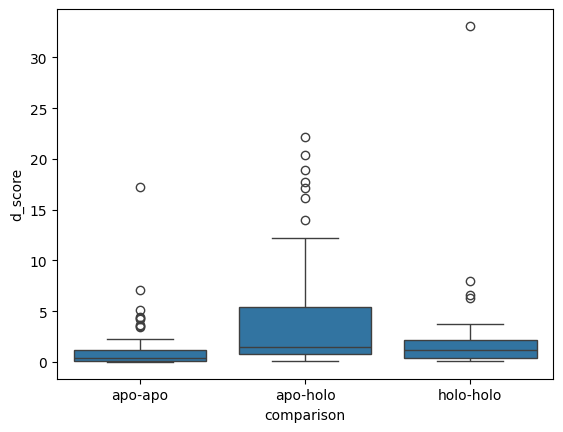

In [46]:
sns.boxplot(peptide_d_scores, x='comparison', y='d_score')

<AxesSubplot: xlabel='d_score', ylabel='Density'>

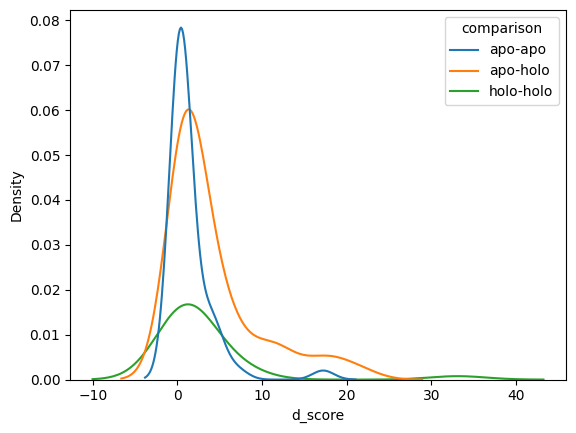

In [47]:
sns.kdeplot(peptide_d_scores, hue='comparison', x='d_score')

In [48]:
peptide_d_scores.groupby('comparison')['d_score'].std()

comparison
apo-apo      2.788440
apo-holo     5.380116
holo-holo    6.488355
Name: d_score, dtype: float64

In [49]:
treatments = [(group, df['d_score'].to_numpy()) for group, df in peptide_d_scores.groupby('comparison')]
print(scipy.stats.kruskal(*[values for _, values in treatments]))

KruskalResult(statistic=26.286830514084954, pvalue=1.958336328723338e-06)


In [50]:
combos = list(itertools.combinations(treatments, 2))

significance_level = 0.05 / len(combos)
print(significance_level)
statistics = []
p_vals = []

for (comparison_x, sample_x), (comparison_y, sample_y) in combos:
    stat, p_val = scipy.stats.ranksums(sample_x, sample_y, alternative='two-sided')

    statistics.append(stat)
    p_vals.append(p_val)

d_score_statistics_peptide = pd.DataFrame({
    'comparison_x': [name for (name, _), _ in combos],
    'comparison_y': [name for _, (name, _) in combos],
    'statistic': statistics,
    'p_val': p_vals,
    'significant': [p_val < significance_level for p_val in p_vals],
})

d_score_statistics_peptide['p_val'] = d_score_statistics_peptide['p_val'].map(lambda num: f'{num:.2e}')

d_score_statistics_peptide

0.016666666666666666


,comparison_x,comparison_y,statistic,p_val,significant
0,apo-apo,apo-holo,-5.022685,5.10e-07,True
1,apo-apo,holo-holo,-2.529214,1.14e-02,True
2,apo-holo,holo-holo,1.781758,7.48e-02,False


#### Per-residue (per length) D-scores of peptides

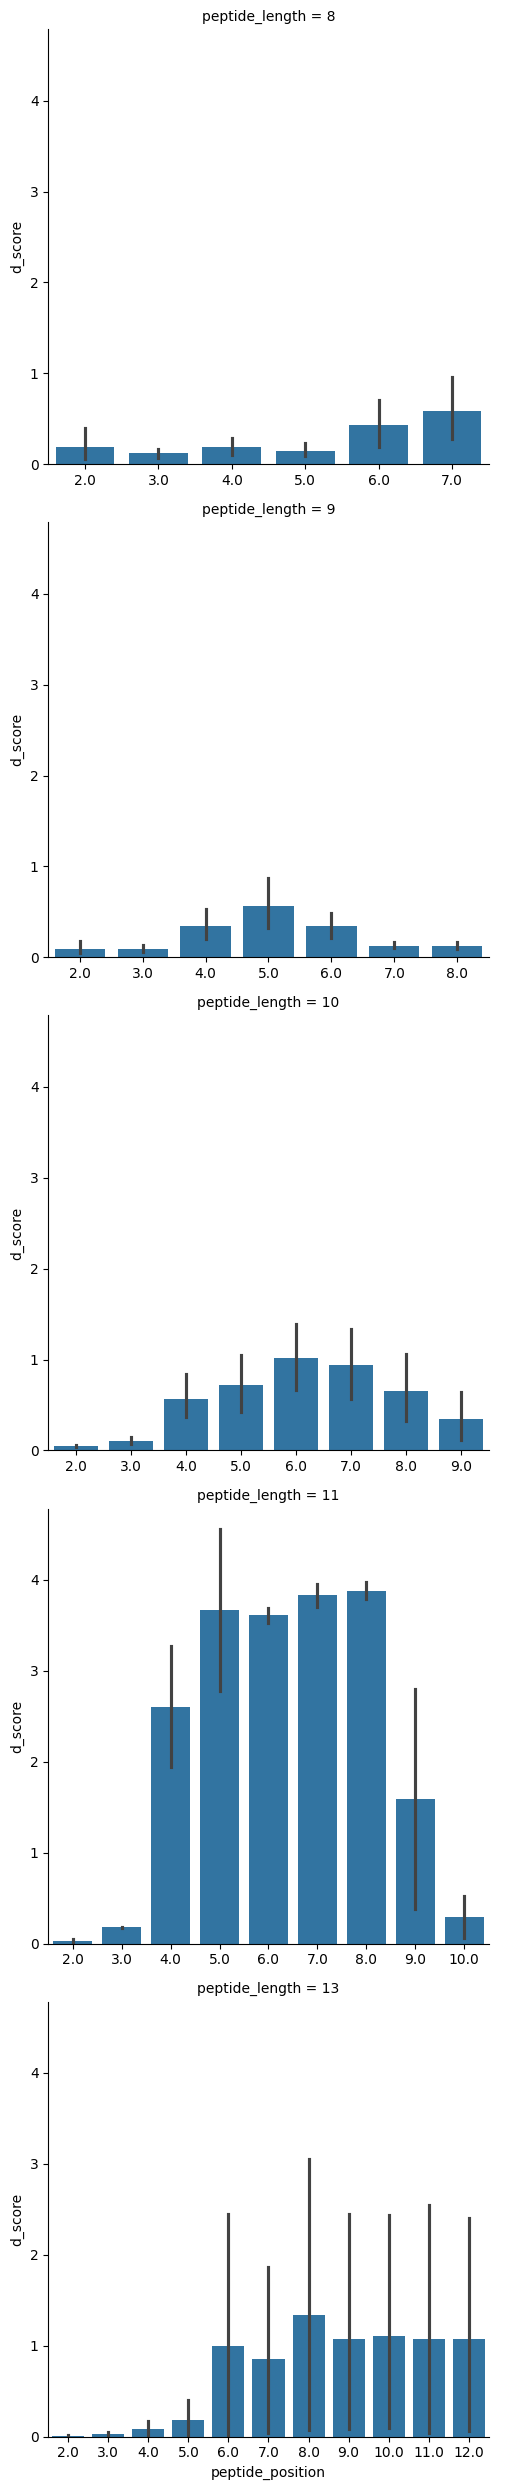

In [51]:
sns.catplot(pmhc_d_score_df.query("chain_type == 'antigen_chain'").sort_values('peptide_position'),
            row='peptide_length',
            x='peptide_position', y='d_score',
            sharex=False,
            kind='bar')

## Conclusion

Overall, the analysis of D-scores shows very similar results to the RMSD calculations done in other notebooks. The flexibility of TCRs seems apparent in the CDR3 loops, and the peptides have flexibility in the canonical TCR contact regions (p3 to pn-1).